In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
from tqdm import tqdm 

class Agent:
    def __init__(self, position, direction, speed):
        # Initialize agent's position, direction, and speed
        self.position = np.array(position)
        # Direction is represented as a unit vector
        self.unit_dir_vec = np.array([np.cos(direction), np.sin(direction)])
        # Desired direction for future movement, initially set to zero vector
        self.desire_direction = np.zeros_like(self.unit_dir_vec)
        self.speed = speed  # Movement speed of the agent
        # Color of the agent (assuming some visualization purpose)
        self.color = (0.0, 0.0, 1.0)  # Blue color
        # Maximum angle by which the agent can turn (5 degrees in radians)
        self.theta_max = 0.0872665
        # ZOR (Zone of Repulsion) influence vector
        self.d_r = np.zeros_like(self.unit_dir_vec)
        # ZOO (Zone of Orientation) influence vector
        self.d_o = np.zeros_like(self.unit_dir_vec)
        # ZOA (Zone of Attraction) influence vector
        self.d_a = np.zeros_like(self.unit_dir_vec)
        # Number of neighbors in each zone
        self.n_r = 0
        self.n_o = 0
        self.n_a = 0

    def update(self, space_size, dt):
        # Update the agent's direction towards its desired direction
        self.turn_towards_desire_direction()
        # Update the agent's position based on its current direction and speed
        self.position += self.unit_dir_vec * self.speed * dt

        # Handle boundary conditions to ensure the agent stays within the space
        if self.position[0] > space_size:
            self.position[0] = 0.0
        elif self.position[0] < 0.0:
            self.position[0] = space_size

        if self.position[1] > space_size:
            self.position[1] = 0.0
        elif self.position[1] < 0.0:
            self.position[1] = space_size

    def turn_towards_desire_direction(self):
        # Normalize current and desired direction vectors
        unit_v1 = self.unit_dir_vec / np.linalg.norm(self.unit_dir_vec)
        unit_v2 = self.desire_direction / np.linalg.norm(self.desire_direction)
        # Calculate the cosine of the angle between the current and desired directions
        cos_theta = np.dot(unit_v1, unit_v2)
        # Compute the angle in radians, clipped to handle numerical issues
        angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))

        # Determine the direction of rotation (clockwise or counterclockwise)
        sign = np.sign(np.cross(self.unit_dir_vec, self.desire_direction))
        # Calculate the actual turn angle, limited by theta_max
        turn_angle = sign * min(angle, self.theta_max)
        # Create a rotation matrix for the computed turn angle
        rotation_matrix = np.array([[np.cos(turn_angle), -np.sin(turn_angle)],
                                    [np.sin(turn_angle), np.cos(turn_angle)]])
        # Rotate the current direction vector
        rotated_vec = np.dot(rotation_matrix, self.unit_dir_vec)
        # Normalize the rotated vector to maintain unit length
        self.unit_dir_vec = rotated_vec / np.linalg.norm(rotated_vec)

    def zor_update(self, r_ij):
        # Update Zone of Repulsion (ZOR) vector with the influence of neighbor j
        self.n_r += 1
        self.d_r += r_ij

    def zoo_update(self, v_j):
        # Update Zone of Orientation (ZOO) vector with the influence of neighbor j
        self.n_o += 1
        self.d_o += v_j

    def zoa_update(self, r_ij):
        # Update Zone of Attraction (ZOA) vector with the influence of neighbor j
        self.n_a += 1
        self.d_a += r_ij

    def evaluate_desire_direction(self, noise):
        # Determine the desired direction based on the zones
        if self.n_r > 0:
            # If there are neighbors in ZOR, repel (move away)
            d_i = -self.d_r
        elif self.n_o > 0 and self.n_a > 0:
            # If both ZOO and ZOA have neighbors, average their influences
            d_i = (self.d_o + self.d_a) * 0.5
        elif self.n_o > 0:
            # If only ZOO has neighbors, align with their direction
            d_i = self.d_o
        elif self.n_a > 0:
            # If only ZOA has neighbors, attract (move towards them)
            d_i = self.d_a
        else:
            # If no neighbors, continue in the current direction
            d_i = self.unit_dir_vec

        # Add random noise to the desired direction
        d_i += noise
        # Normalize the desired direction to maintain unit length
        norm = np.linalg.norm(d_i)
        if norm != 0:
            d_i /= norm

        # Update the desired direction
        self.desire_direction = d_i

import matplotlib.pyplot as plt
from tqdm import tqdm

class Swarm:
    def __init__(self, N, speed, space_size, sigma, rep_r, orien_r, attr_r, dt):
        # Initialize swarm parameters
        self.num_agents = N  # Number of agents in the swarm
        self.dt = dt  # Time step for the simulation
        self.space_size = space_size  # Size of the space in which the swarm operates
        self.sigma = sigma  # Standard deviation of the noise applied to agents' movement

        # Initialize agents
        self.agents = Swarm.__initialize_agent(N, speed)

        # Define radii for different zones of interaction
        self.repul_radius = rep_r  # Repulsion radius
        self.orien_radius = orien_r  # Orientation radius
        self.attrac_radius = attr_r  # Attraction radius

    def __initialize_agent(N, speed):
        # Initialize each agent at a random position near a source point with random direction
        source = (30, 30)  # Starting point for the swarm
        return [Agent(np.random.uniform(source[0] - 10, source[1] + 10, 2), np.random.rand() * 2 * np.pi, speed) for _ in range(N)]

    def reset_swarm(self):
        # Reset the forces and neighbor counts for each agent
        for agent in self.agents:
            agent.d_r = np.zeros_like(agent.unit_dir_vec)  # Reset repulsion force vector
            agent.d_o = np.zeros_like(agent.unit_dir_vec)  # Reset orientation force vector
            agent.d_a = np.zeros_like(agent.unit_dir_vec)  # Reset attraction force vector
            agent.n_r = 0  # Reset repulsion neighbors count
            agent.n_a = 0  # Reset attraction neighbors count
            agent.n_o = 0  # Reset orientation neighbors count

    def generate_noise(self, sigma):
        # Generate noise for the agent's direction, based on the provided sigma (standard deviation)
        return np.random.normal(0, sigma)

    def compute_polarization(self):
        """
        计算群体极化度，范围[0,1]，越接近1代表全体方向越一致
        """
        sum_dir = np.sum([agent.unit_dir_vec for agent in self.agents], axis=0)
        polarization = np.linalg.norm(sum_dir) / self.num_agents
        return polarization

    def compute_angular_momentum(self):
        """
        计算群体归一化角动量（范围在0~1之间，表示方向绕质心最大集体旋转时为1，没有旋转为0）
        """
        positions = np.array([agent.position for agent in self.agents])
        dirs = np.array([agent.unit_dir_vec for agent in self.agents])
        center_of_mass = np.mean(positions, axis=0)
        deltas = positions - center_of_mass
    
        # # 归一化 deltas（否则远离中心分量比近的更大，对群体角动量影响会大）
        # deltas_norm = np.linalg.norm(deltas, axis=1)
        # dirs_norm = np.linalg.norm(dirs, axis=1)
        # # 防止除零
        # norm_factor = deltas_norm * dirs_norm
        # norm_factor[norm_factor == 0] = 1
    
        # 单位化后的叉积
        unit_cross = deltas[:, 0] * dirs[:, 1] - deltas[:, 1] * dirs[:, 0]
        unit_cross = unit_cross / np.abs(unit_cross).max()
        #import pdb; pdb.set_trace()
        normalized_angular_momentum = np.linalg.norm(np.sum(unit_cross)) / self.num_agents
        return normalized_angular_momentum

        
    def simulate(self):
        # Simulate one time step for all agents
        self.reset_swarm()  # Reset the forces and neighbor counts

        for agent in self.agents:
            c_i = agent.position  # Current position of the agent
            for other_agent in self.agents:
                c_j = other_agent.position  # Position of another agent
                r_ij = (c_j - c_i)  # Vector from agent to another agent
                distance = np.linalg.norm(r_ij)  # Euclidean distance between the two agents
                distances = np.minimum(distance, self.space_size - distance)  # Handle edge cases by wrapping around

                if distance != 0:  # If distance is not zero (to avoid division by zero)
                    r_ij /= distance  # Normalize the distance vector
                    if distance < self.repul_radius:
                        agent.zor_update(r_ij)  # Update agent behavior if within the repulsion radius
                    else:
                        v_j = other_agent.unit_dir_vec  # Direction vector of the other agent
                        if distance >= self.repul_radius and distance < self.orien_radius:
                            agent.zoo_update(v_j)  # Update agent behavior if within the orientation radius
                        elif distance >= self.orien_radius and distance < self.attrac_radius:
                            agent.zoa_update(r_ij)  # Update agent behavior if within the attraction radius

            if agent.n_o > 0:
                agent.d_o /= (agent.n_o + 1)  # Average orientation direction if there are orientation neighbors

            noise = self.generate_noise(self.sigma)  # Generate noise to add to the agent's direction
            agent.evaluate_desire_direction(noise)  # Calculate the desired direction considering all forces

        for agent in self.agents:
            agent.update(self.space_size, self.dt)  # Update the agent's position based on its desired direction

class Simulation:
    def __init__(self, num_agent=100, speed=2.0, space_size=100, sigma=0.1, rep_r=3, orien_r=7, attr_r=12, dt=1.0):
        # 初始化群体
        self.swarm = Swarm(num_agent, speed, space_size, sigma, rep_r, orien_r, attr_r, dt)
        self.num_agent = num_agent

    def run(self, steps=100):
        polarization_list = []
        angular_momentum_list = []
        trajectories = [[] for _ in range(self.num_agent)]

        for step in tqdm(range(steps)):
            polarization = self.swarm.compute_polarization()
            angular_momentum = self.swarm.compute_angular_momentum()
            polarization_list.append(polarization)
            angular_momentum_list.append(angular_momentum)
            for idx, agent in enumerate(self.swarm.agents):
                # 存储当前位置的副本
                trajectories[idx].append(agent.position.copy())
            
            # 进行一步模拟
            self.swarm.simulate()

        # 转为 numpy 数组，方便后续处理
        trajectories = [np.array(traj) for traj in trajectories]

        return trajectories, polarization_list,  angular_momentum_list 

        

N = 30       # Number of agents in the swarm
r_rep = 5    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 30   # Radius of orientation (agents align their direction with others within this distance)
r_att = 32   # Radius of attraction (agents are attracted to others within this distance)
speed = 1.0  # Speed at which agents move
sigma = 0.1  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 150  # Size of the 2D space in which the agents move

# Initialize the simulation with the specified parameters
sim = Simulation(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt)

trajectories, polarization_list,  angular_momentum_list = sim.run(steps=400)


100%|██████████| 400/400 [00:03<00:00, 117.27it/s]


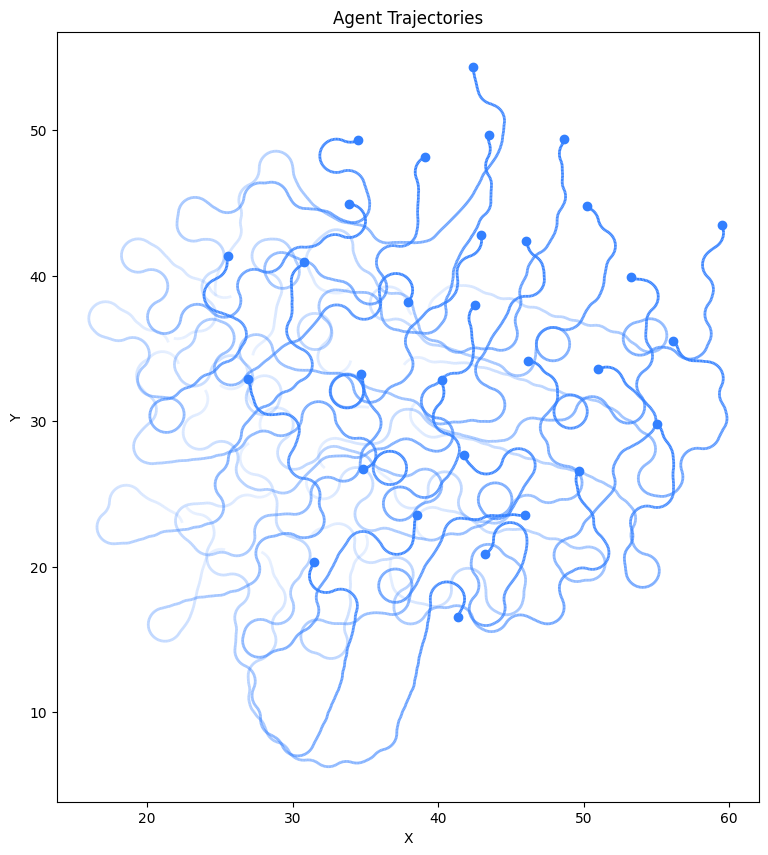

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_trajectories_with_time_alpha(trajectories):
    """
    trajectories: List of shape [N_agents][steps, 2]
    """
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    
    for traj in trajectories:
        # 每个轨迹分成steps-1个线段
        points = traj.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        n_steps = len(traj)
        # 计算每个线段的透明度，时间越大越不透明
        # 例如alpha从0.1递增到1.0
        alphas = np.linspace(0.1, 1.0, n_steps-1)
        # 每个线段一个颜色，alpha不同
        colors = np.zeros((n_steps-1, 4))
        colors[:, 0] = 0.2  # 红色分量
        colors[:, 1] = 0.5  # 绿色分量
        colors[:, 2] = 1.0  # 蓝色分量
        colors[:, 3] = alphas  # alpha分量

        lc = LineCollection(segments, colors=colors, linewidths=2)
        ax.add_collection(lc)

        # 可选：画出最后一点
        ax.plot(traj[-1,0], traj[-1,1], 'o', color=(0.2,0.5,1.0), markersize=6)

    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Agent Trajectories')
    plt.show()


plot_trajectories_with_time_alpha(trajectories)


100%|██████████| 500/500 [00:43<00:00, 11.61it/s]


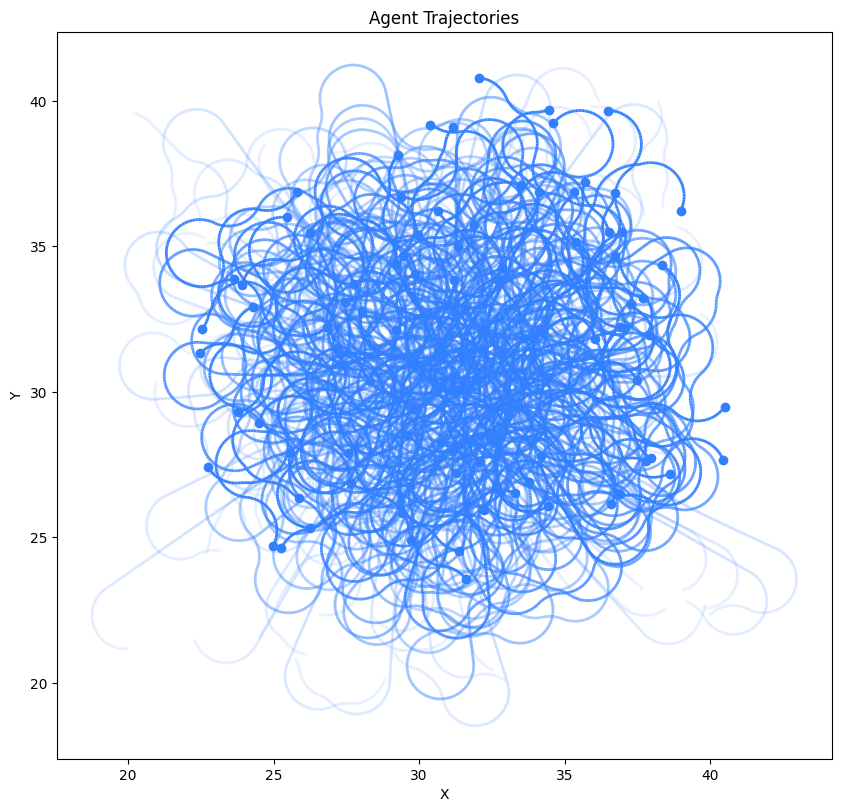

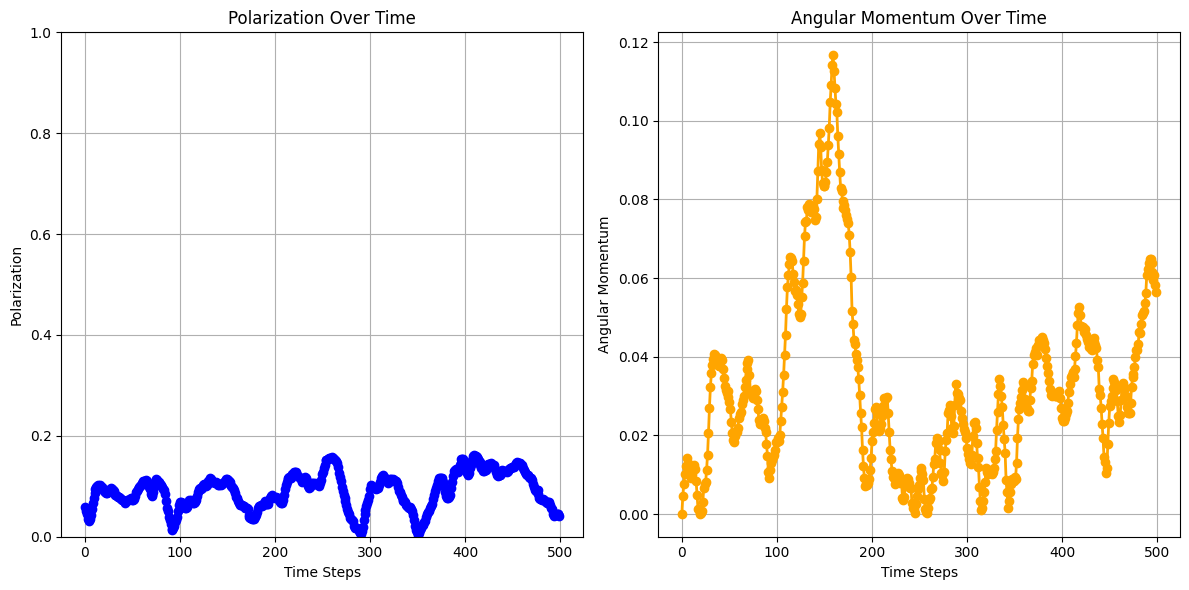

In [3]:
def main(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt, steps=500):
    sim = Simulation(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt)
    trajectories, polarization_list, angular_momentum_list = sim.run(steps=steps)
    plot_trajectories_with_time_alpha(trajectories)
    # 绘制极化度和角动量
    plt.figure(figsize=(12, 6))
    
    # 绘制极化度
    plt.subplot(1, 2, 1)
    plt.plot(polarization_list, color='blue', linewidth=2, marker='o')
    plt.title("Polarization Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Polarization")
    plt.ylim(0, 1)  # 极化度范围在[0, 1]
    plt.grid()
    
    # 绘制角动量
    plt.subplot(1, 2, 2)
    plt.plot(angular_momentum_list, color='orange', linewidth=2, marker='o')
    plt.title("Angular Momentum Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Angular Momentum")
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    return trajectories

N = 10       # Number of agents in the swarm
r_rep = 1    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 2   # Radius of orientation (agents align their direction with others within this distance)
r_att = 20   # Radius of attraction (agents are attracted to others within this distance)
speed = 1.0  # Speed at which agents move
sigma = 0.05  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 500  # Size of the 2D space in which the agents move
steps = 500

trajectories = main(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt, steps)

12.2


100%|██████████| 500/500 [00:34<00:00, 14.65it/s]


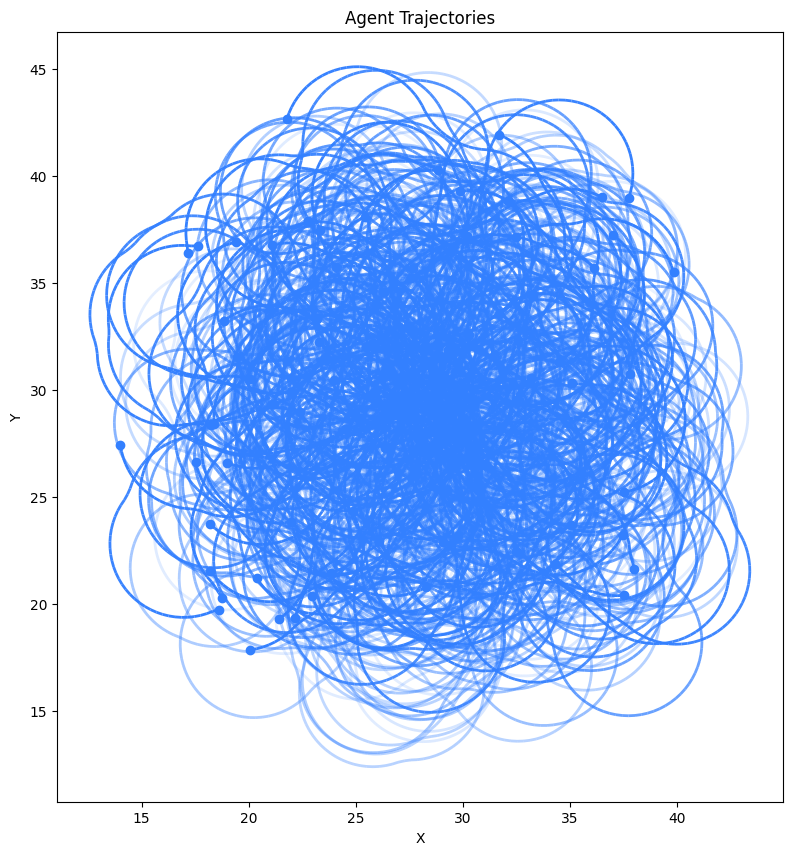

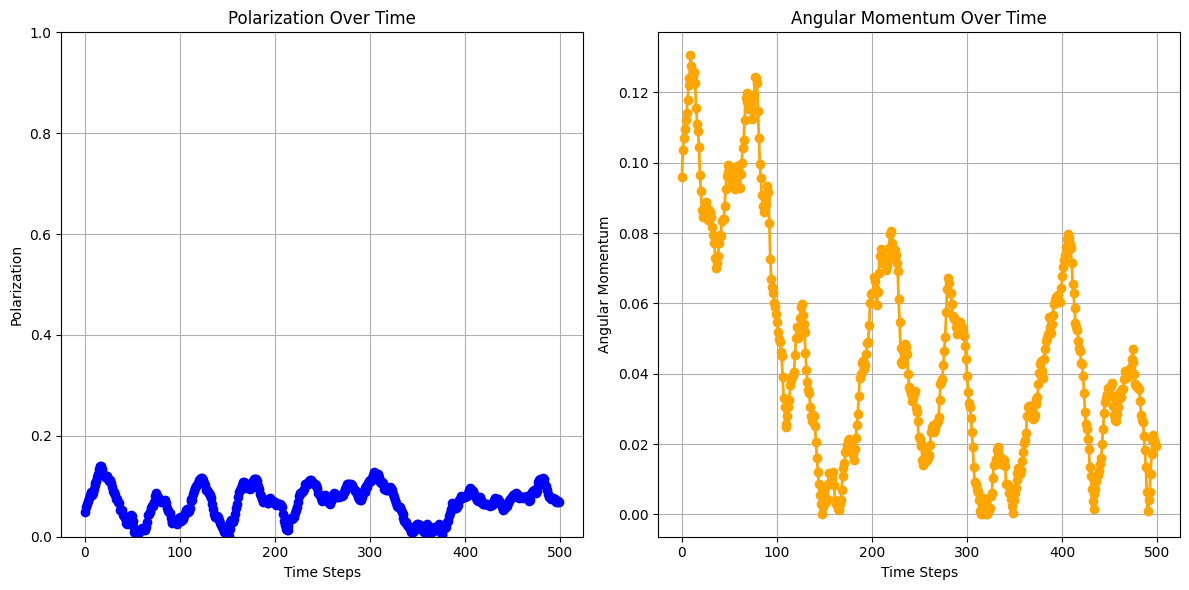

12.3


100%|██████████| 500/500 [00:34<00:00, 14.66it/s]


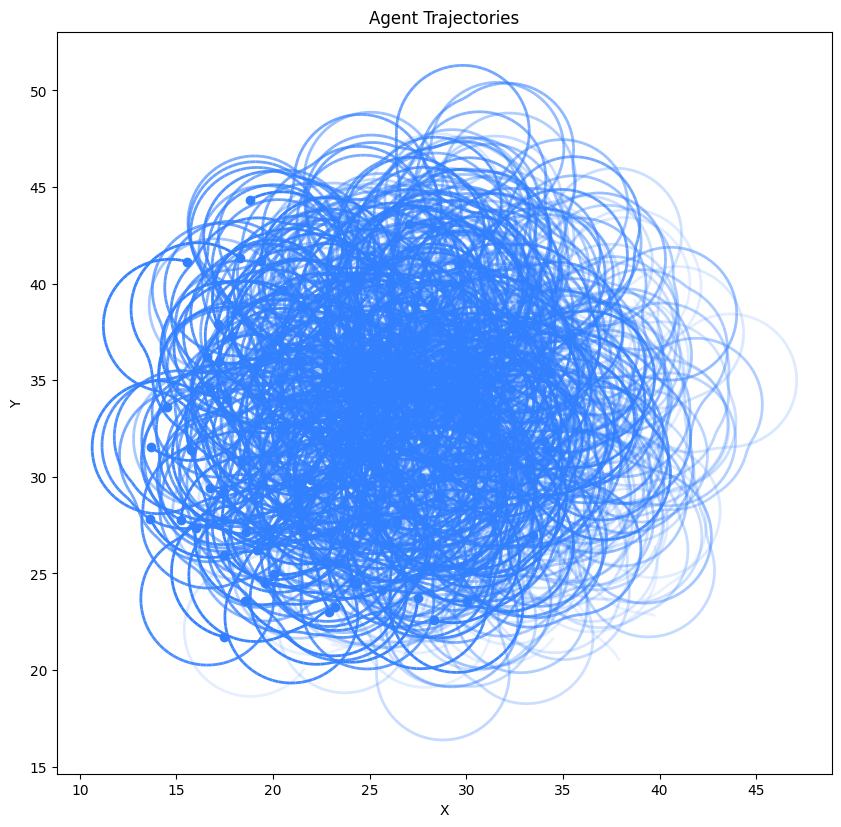

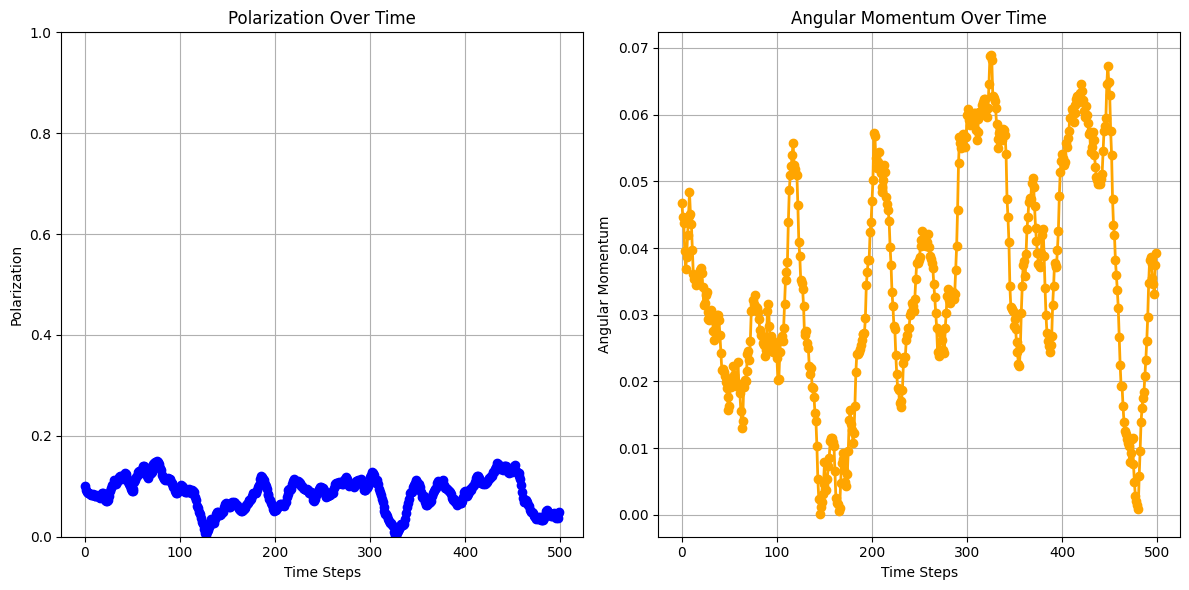

12.4


100%|██████████| 500/500 [00:34<00:00, 14.61it/s]


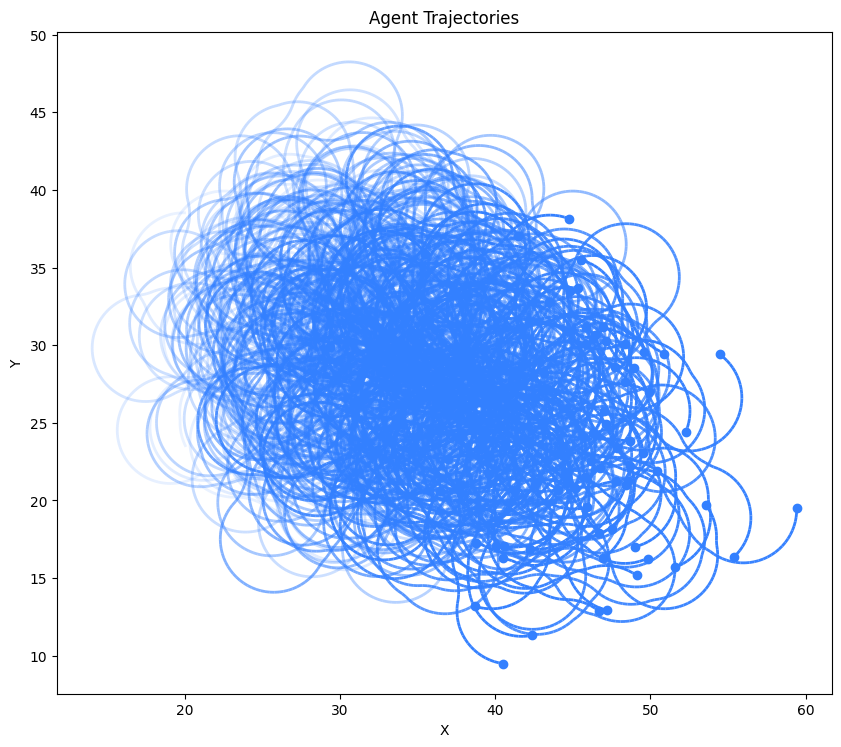

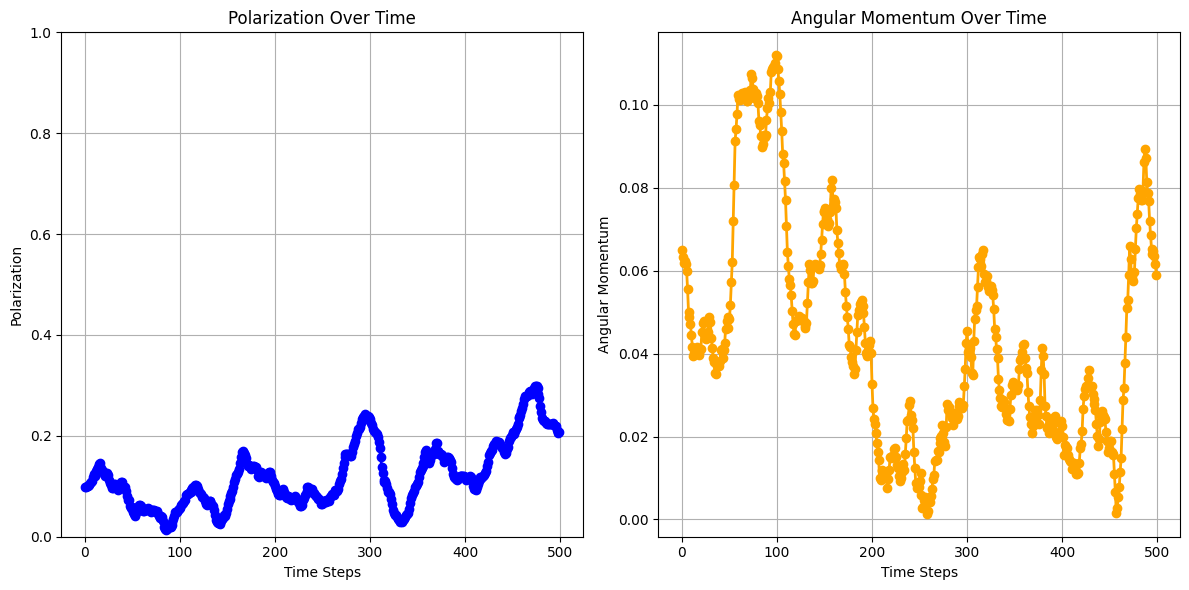

12.6


100%|██████████| 500/500 [00:34<00:00, 14.53it/s]


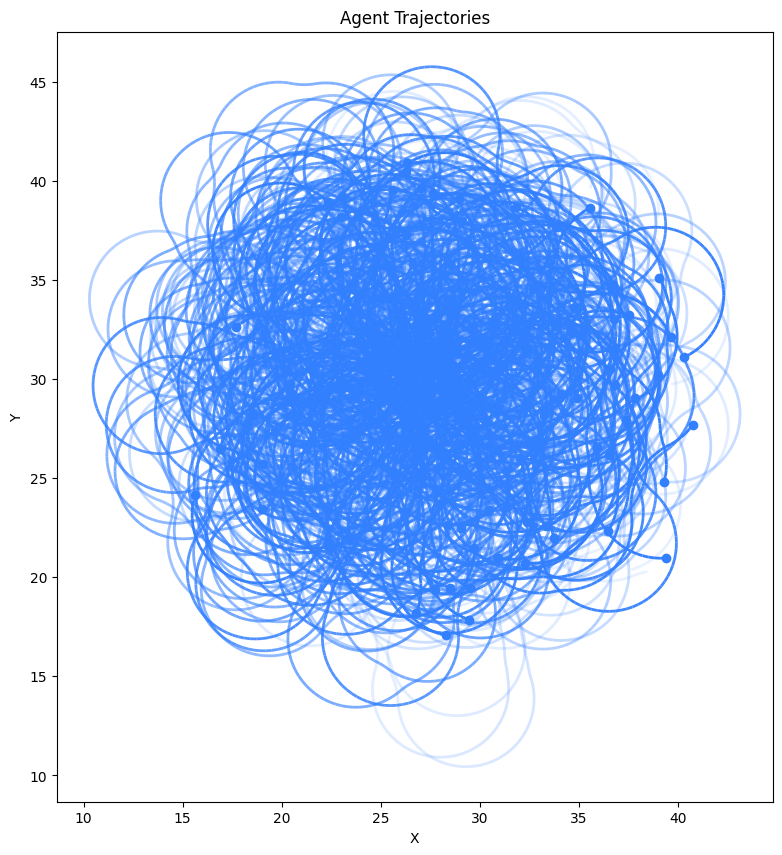

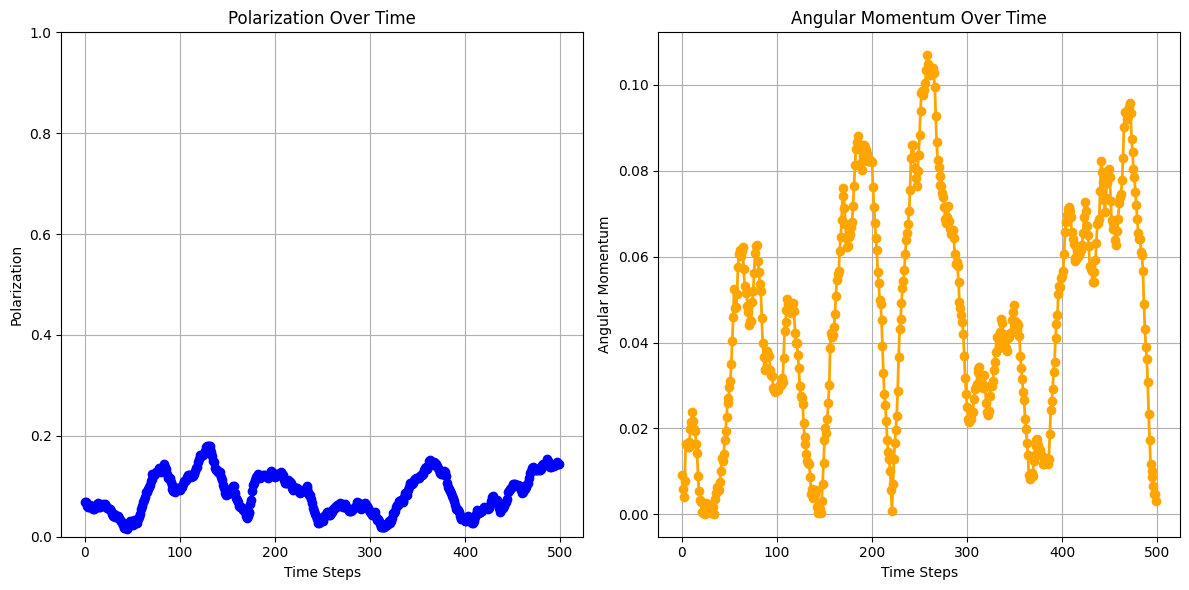

12.8


100%|██████████| 500/500 [00:34<00:00, 14.55it/s]


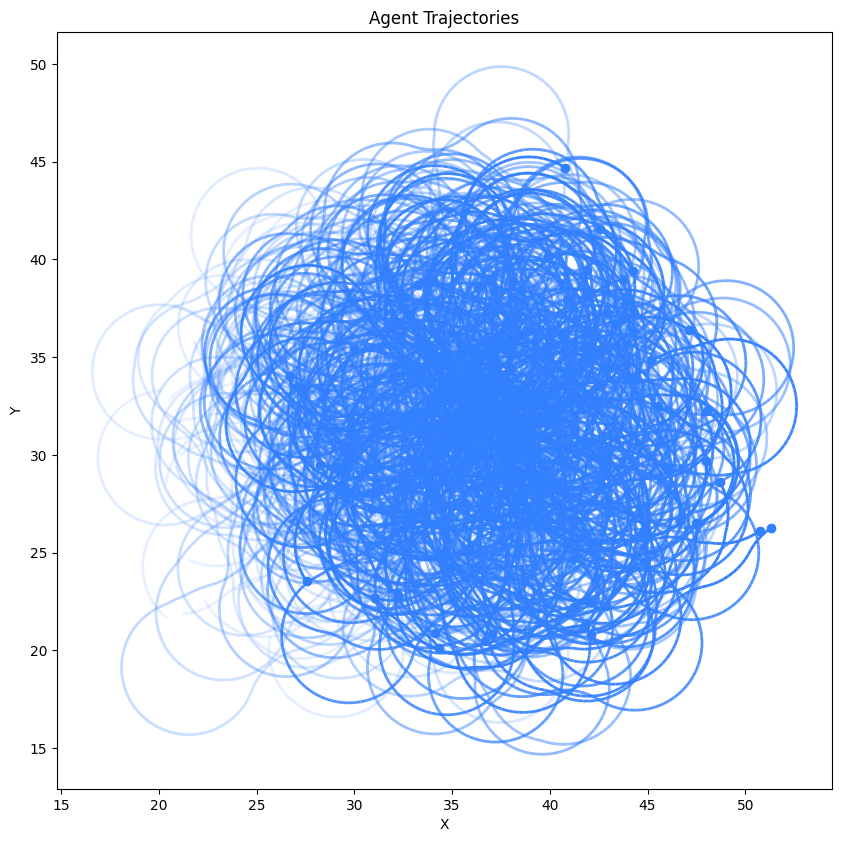

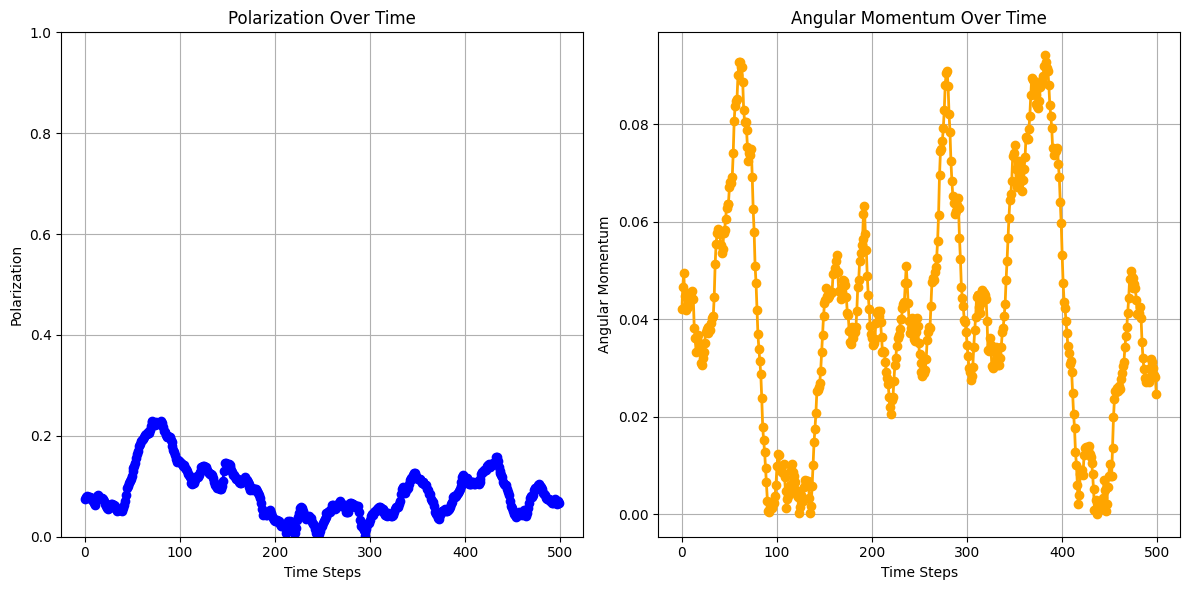

13


100%|██████████| 500/500 [00:34<00:00, 14.42it/s]


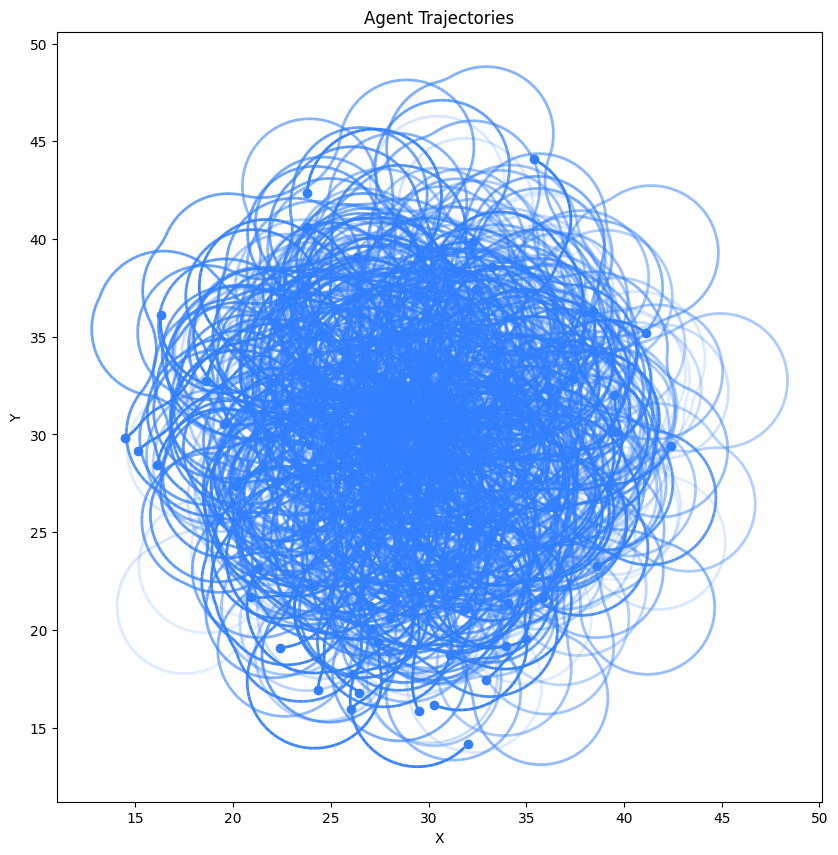

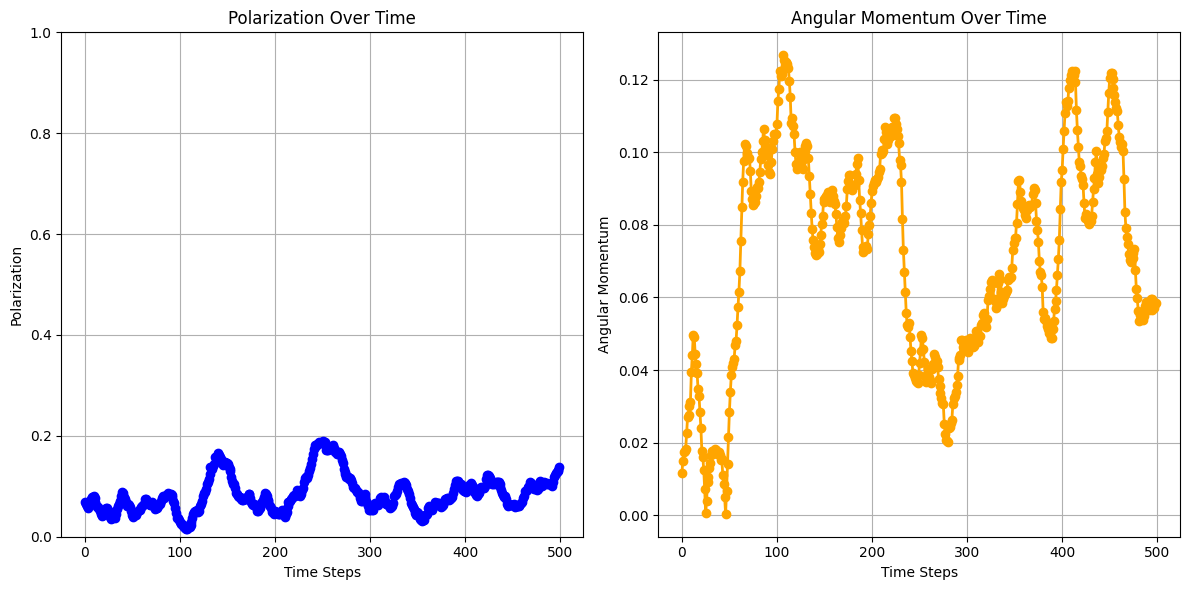

13.5


100%|██████████| 500/500 [00:34<00:00, 14.45it/s]


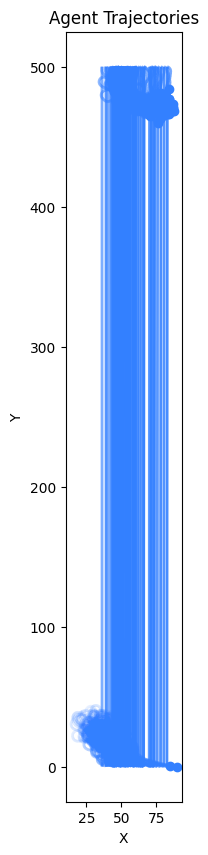

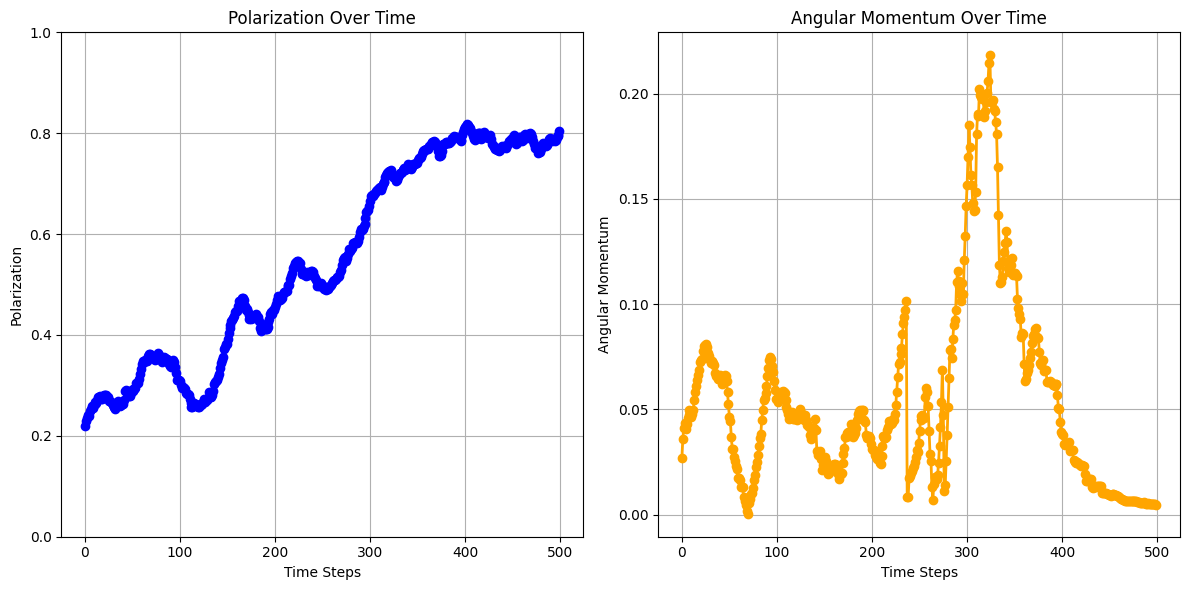

14


100%|██████████| 500/500 [00:34<00:00, 14.63it/s]


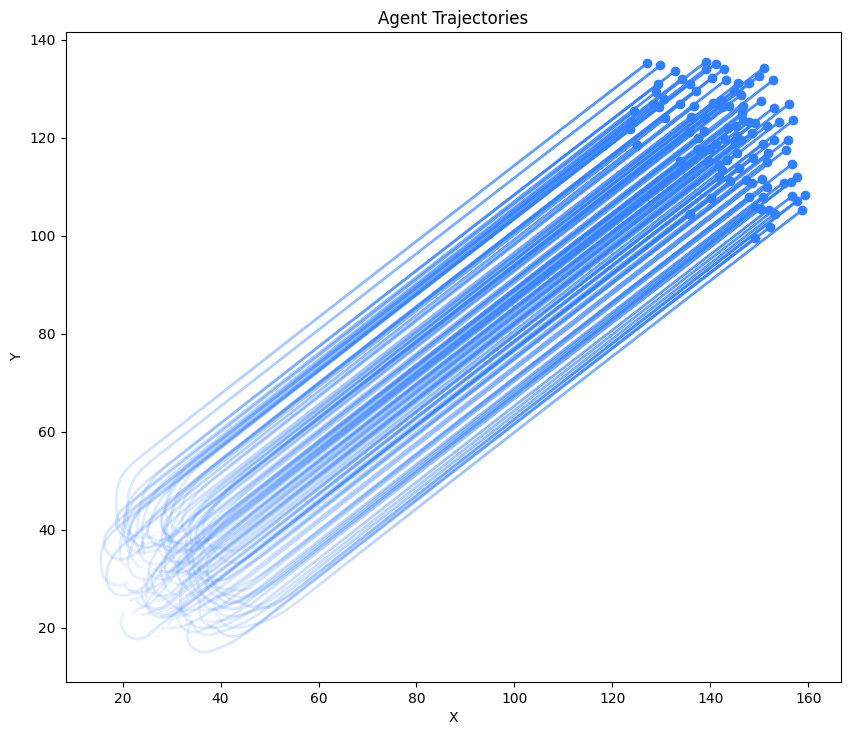

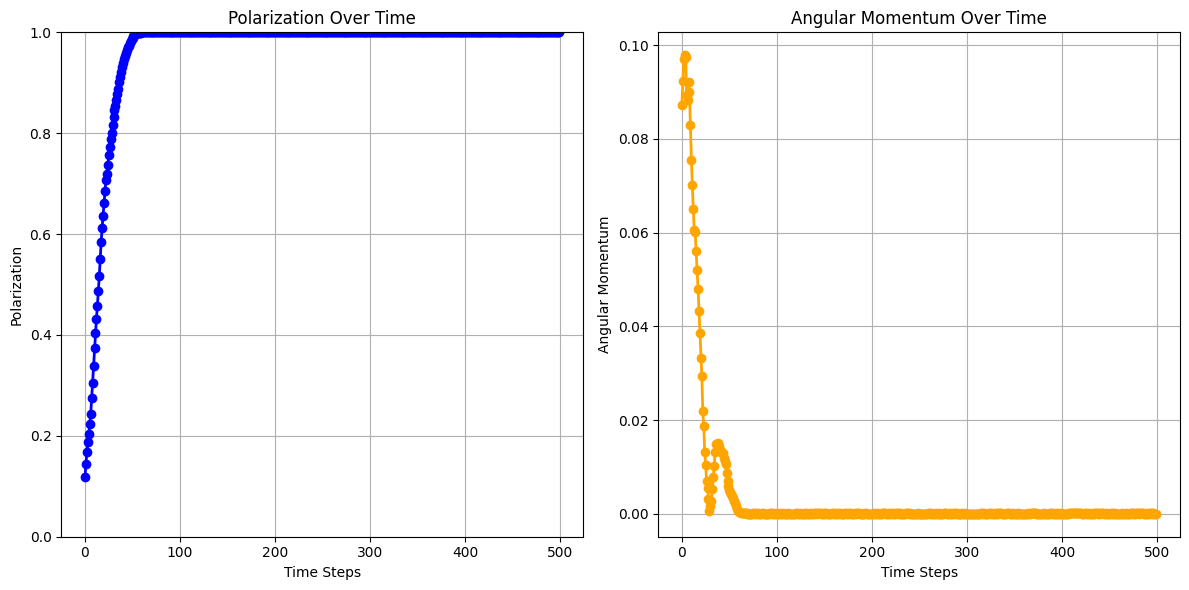

In [10]:
N = 100       # Number of agents in the swarm
r_rep = 1    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 2   # Radius of orientation (agents align their direction with others within this distance)
r_att = 14   # Radius of attraction (agents are attracted to others within this distance)
speed = 3.0  # Speed at which agents move
sigma = 0.01  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 500  # Size of the 2D space in which the agents move
steps = 500

for r_ori in [12.2,12.3,12.4,12.6,12.8,13,13.5,14]:
    print(r_ori)
    main(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt, steps)

100%|██████████| 10000/10000 [01:20<00:00, 124.01it/s]


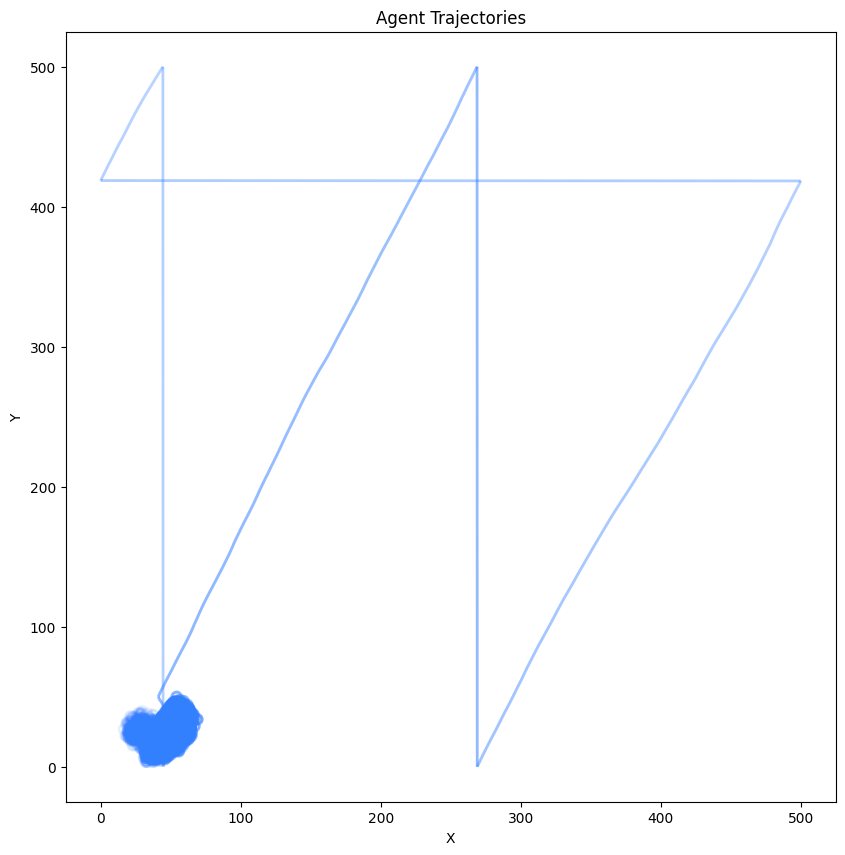

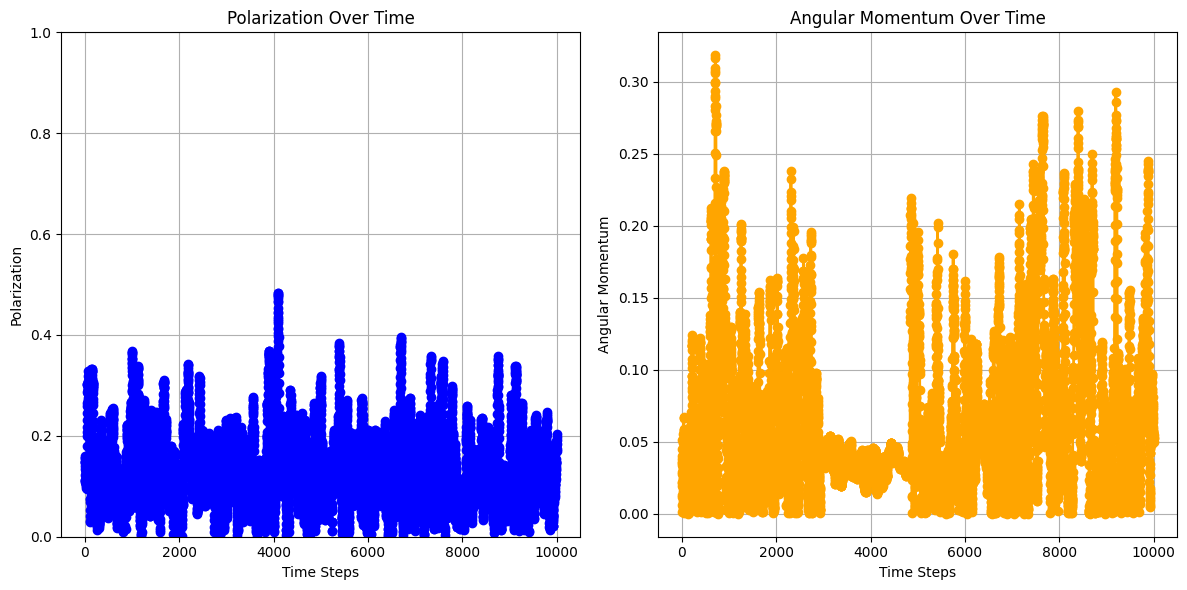

In [8]:
N = 30       # Number of agents in the swarm
r_rep = 1    # Radius of repulsion (agents will try to avoid being within this distance of each other)
r_ori = 8  #12 
r_att = 14   # Radius of attraction (agents are attracted to others within this distance)
speed = 3.0  # Speed at which agents move
sigma = 0.01  # Noise factor for randomness in movement
dt = 0.1     # Time step for simulation updates
space_size = 500  # Size of the 2D space in which the agents move
steps = 10000

trajectories_swarm = main(N, speed, space_size, sigma, r_rep, r_ori, r_att, dt, steps)


In [9]:
trajectories_swarm = np.array(trajectories_swarm)
trajectories_swarm = trajectories_swarm.transpose(1,0,2).reshape(steps, -1)
data_mean_df = pd.DataFrame(trajectories_swarm)
data_mean_df.columns = [f'C{v:02d}' for v in range(data_mean_df.shape[1])]
data_mean_df = data_mean_df.reset_index()              
data_mean_df

index        C00        C01        C02        C03        C04        C05  \
0         0  23.948022  32.437623  31.071555  39.004763  23.377133  29.898157   
1         1  23.718301  32.244677  31.032766  39.302245  23.118508  29.746128   
2         2  23.506271  32.032443  30.968198  39.595214  22.874116  29.572137   
3         3  23.313545  31.802537  30.878341  39.881441  22.645820  29.377507   
4         4  23.141590  31.556709  30.763880  40.158747  22.435355  29.163721   
...     ...        ...        ...        ...        ...        ...        ...   
9995   9995  47.952963  23.411198  56.299494  34.576291  47.723117  26.549950   
9996   9996  48.189754  23.595398  56.127297  34.330632  47.433249  26.627256   
9997   9997  48.409591  23.799535  55.934344  34.100916  47.151221  26.729532   
9998   9998  48.610800  24.022055  55.722105  33.888891  46.879180  26.855999   
9999   9999  48.791848  24.261264  55.492195  33.696171  46.619197  27.005694   

            C06        C07        C08  ...        C50        C51        C52  \
0     25.113659  35.142847  24.665471  ...  36.558189  20.996513  34.569066   
1     25.413444  35.154216  24.795739  ...  36.827466  20.864265  34.316075   
2     25.711097  35.191669  24.949065  ...  37.107245  20.755988  34.049995   
3     26.004353  35.254922  25.101755  ...  37.395396  20.672509  33.772851   
4     26.290980  35.343494  25.251651  ...  37.689727  20.614460  33.486751   
...         ...        ...        ...  ...        ...        ...        ...   
9995  40.606886  30.108816  44.798160  ...  49.523215  39.096201  51.855989   
9996  40.745574  29.842798  44.621280  ...  49.814777  39.166853  52.089638   
9997  40.906919  29.589879  44.466192  ...  50.111387  39.211825  52.305998   
9998  41.089693  29.351985  44.334076  ...  50.410788  39.230775  52.503423   
9999  41.292505  29.130926  44.225937  ...  50.710701  39.223558  52.680409   

            C53        C54        C55        C56        C57        C58  \
0     30.720956  39.114584  30.486720  30.648524  23.063777  28.788294   
1     30.559724  38.896227  30.281000  30.912135  22.920567  28.884003   
2     30.421155  38.660772  30.095095  31.187225  22.800877  28.954568   
3     30.306303  38.410011  29.930418  31.471700  22.705618  28.999451   
4     30.216044  38.145850  29.788223  31.763394  22.635515  29.018311   
...         ...        ...        ...        ...        ...        ...   
9995  25.639446  51.362043  36.225051  56.560927  29.887388  45.929147   
9996  25.827616  51.084258  36.111757  56.602199  30.184535  46.218419   
9997  26.035434  50.817404  35.974684  56.617416  30.484149  46.506004   
9998  26.261318  50.563513  35.814874  56.606461  30.783949  46.794931   
9999  26.503549  50.324516  35.633544  56.569419  31.081653  47.089796   

            C59  
0     21.813153  
1     22.097476  
2     22.389059  
3     22.685683  
4     22.985089  
...         ...  
9995  31.550317  
9996  31.629825  
9997  31.715233  
9998  31.795988  
9999  31.851255  

[10000 rows x 61 columns]

In [10]:
data_mean_df.to_csv('../dataset/Couzin/swarm_30_10000.csv', index=False, float_format='%.4f')